In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
# data cleaning and preprocessing

import pandas as pd

# Load the dataset
df = pd.read_csv('algeria_forest.csv')

# 1. Check for missing values
print("Missing values:\n", df.isnull().sum())

# 2. Remove rows with missing values
data_cleaned = df.dropna()

# 3. Check for duplicates
print(f"Duplicate rows: {data_cleaned.duplicated().sum()}")

# Remove duplicates if found
data_cleaned = data_cleaned.drop_duplicates()

# 4. Handle outliers (for example, limit the area field)
# Removing extreme outliers in 'area' (burnt area > 90th percentile)
area_threshold = data_cleaned['area'].quantile(0.95)
data_cleaned = data_cleaned[data_cleaned['area'] <= area_threshold]

# 5. Display the cleaned data summary
print(data_cleaned.describe())



Missing values:
 X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64
Duplicate rows: 4
                X           Y        FFMC         DMC          DC         ISI  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     4.655031    4.293634   90.608419  110.203901  547.009446    9.033881   
std      2.296018    1.216324    5.642752   64.134721  249.861522    4.623480   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   61.450000  435.500000    6.350000   
50%      4.000000    4.000000   91.600000  108.300000  661.800000    8.400000   
75%      7.000000    5.000000   92.900000  141.300000  714.300000   10.900000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain        area  
count  487.

In [4]:
# correlation matrix calculation

# Load the cleaned dataset
df = pd.read_csv('cleaned_algeria_forest.csv')

# Encode categorical variables (month, day) as integers for correlation matrix calculation
df['month'] = df['month'].astype('category').cat.codes
df['day'] = df['day'].astype('category').cat.codes

# Strip whitespace from column names to avoid issues
df.columns = df.columns.str.strip()

# Check the columns to ensure there are no leading/trailing spaces
print(df.columns)

# Ensure correct data types
# coerce means that if a column is not of the correct type, it will be set to NaN
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
df['wind'] = pd.to_numeric(df['wind'], errors='coerce')
df['rain'] = pd.to_numeric(df['rain'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')
df['area'] = pd.to_numeric(df['area'], errors='coerce')

# Calculate covariance matrix
# covariance matrix is a matrix in which the element in the i, j position is the covariance between the i-th and j-th elements of a random vector.
cov_matrix = df[['temp', 'RH', 'wind', 'rain', 'month', 'day', 'area']].cov()

print("Covariance matrix:")
print(cov_matrix)







Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')
Covariance matrix:
            temp          RH      wind      rain      month       day  \
temp   34.120516  -50.743325 -2.511109  0.130400  -2.173693  1.520512   
RH    -50.743325  272.722649  2.288997  0.503532  -6.762838 -3.073170   
wind   -2.511109    2.288997  3.264806  0.034512  -0.943490 -0.145516   
rain    0.130400    0.503532  0.034512  0.092968  -0.105480  0.032693   
month  -2.173693   -6.762838 -0.943490 -0.105480  19.045107 -1.273544   
day     1.520512   -3.073170 -0.145516  0.032693  -1.273544  3.734589   
area   -1.623852    1.061087  1.402956  0.046842   1.899359 -0.584250   

            area  
temp   -1.623852  
RH      1.061087  
wind    1.402956  
rain    0.046842  
month   1.899359  
day    -0.584250  
area   72.244095  


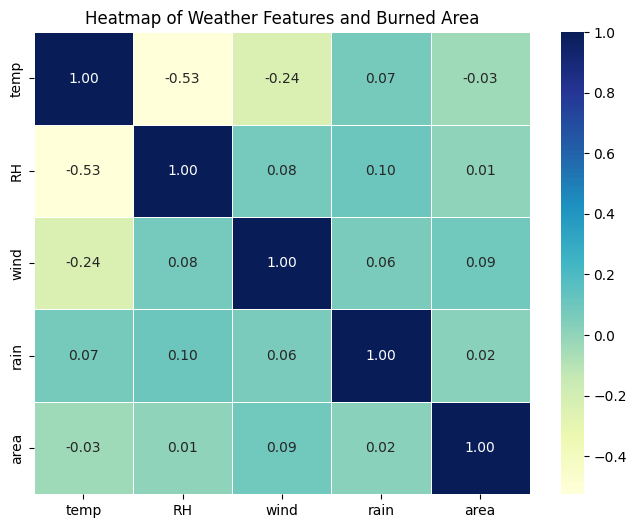

In [5]:
# Heatmap of selected features and target variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset

# Select relevant features
selected_features = ['temp', 'RH', 'wind', 'rain', 'area']

# Compute the correlation matrix
correlation_matrix = df[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=0.5)
plt.title("Heatmap of Weather Features and Burned Area")
plt.show()

In [6]:
# Define a custom dataset class for the data
class ForestFireDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        features = torch.tensor([sample['temp'], sample['RH'], sample['wind'], sample['rain'], sample['month'], sample['day']], dtype=torch.float32)
        target = torch.tensor([sample['area']], dtype=torch.float32)
        return features, target


In [7]:
#  the dataset and data loaders
dataset = ForestFireDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
#  neural network model
class ForestFireModel(nn.Module):
    def __init__(self):
        super(ForestFireModel, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
# Initialize the models, loss functions, and optimizers
nn_model = ForestFireModel()
nn_criterion = nn.MSELoss()
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

svm_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lr_model = LinearRegression()


In [10]:
# Train the models
for epoch in range(100):
    for features, target in data_loader:
        nn_optimizer.zero_grad()
        nn_output = nn_model(features)
        nn_loss = nn_criterion(nn_output, target)
        nn_loss.backward()
        nn_optimizer.step()
    print(f'Epoch {epoch+1}, NN Loss: {nn_loss.item()}')


Epoch 1, NN Loss: 11.576356887817383
Epoch 2, NN Loss: 116.21759033203125
Epoch 3, NN Loss: 51.99190902709961
Epoch 4, NN Loss: 46.9332275390625
Epoch 5, NN Loss: 18.8784236907959
Epoch 6, NN Loss: 14.858070373535156
Epoch 7, NN Loss: 16.243938446044922
Epoch 8, NN Loss: 36.79971694946289
Epoch 9, NN Loss: 51.24488067626953
Epoch 10, NN Loss: 12.52719783782959
Epoch 11, NN Loss: 10.317220687866211
Epoch 12, NN Loss: 17.96245765686035
Epoch 13, NN Loss: 10.357512474060059
Epoch 14, NN Loss: 15.102432250976562
Epoch 15, NN Loss: 21.410533905029297
Epoch 16, NN Loss: 22.056230545043945
Epoch 17, NN Loss: 79.30623626708984
Epoch 18, NN Loss: 16.39592170715332
Epoch 19, NN Loss: 23.11208152770996
Epoch 20, NN Loss: 18.893375396728516
Epoch 21, NN Loss: 97.29656219482422
Epoch 22, NN Loss: 289.1924743652344
Epoch 23, NN Loss: 41.42900848388672
Epoch 24, NN Loss: 100.93761444091797
Epoch 25, NN Loss: 68.64896392822266
Epoch 26, NN Loss: 12.40984058380127
Epoch 27, NN Loss: 14.447135925292969


In [11]:
svm_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])
rf_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])
lr_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])


LinearRegression()

In [12]:
# Evaluate the models
nn_model.eval()
total_nn_loss = 0
nn_predictions = []
with torch.no_grad():
    for features, target in data_loader:
        nn_output = nn_model(features)
        nn_loss = nn_criterion(nn_output, target)
        total_nn_loss += nn_loss.item()
        nn_predictions.extend(nn_output.cpu().numpy().flatten())
mean_nn_loss = total_nn_loss / len(data_loader)
print(f'Mean NN Loss: {mean_nn_loss:.6f}')

svm_predictions = svm_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])
rf_predictions = rf_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])
lr_predictions = lr_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])





Mean NN Loss: 66.781684


In [13]:

# Calculate the total loss of vegetation for each model
total_loss_vegetation_svm = np.sum(svm_predictions)
print(f'Total Loss of Vegetation (SVM): {total_loss_vegetation_svm:.4f} ha')

total_loss_vegetation_rf = np.sum(rf_predictions)
print(f'Total Loss of Vegetation (Random Forest): {total_loss_vegetation_rf:.4f} ha')

total_loss_vegetation_lr = np.sum(lr_predictions)
print(f'Total Loss of Vegetation (Linear Regression): {total_loss_vegetation_lr:.4f} ha')

# Mean accuracy and distance covered for neural network model
nn_predictions = np.clip(np.array(nn_predictions), 0, np.max(df['area']))
df['area'] = np.clip(df['area'], 0.001, np.max(df['area']))  # Clip area values to avoid division by zero
mean_accuracy = np.mean(np.abs(nn_predictions - df['area']) / (df['area'] + 1e-8))  # Add a small value to avoid division by zero
print(f'Mean Accuracy (Neural Network): {mean_accuracy:.4f}')

distance_covered = np.sum(nn_predictions) * 0.1  # Assuming 0.1 km per ha
print(f'Distance Going to Cover (Neural Network): {distance_covered:.4f} km')

# Calculate total burnt area by models used
total_burnt_by_models = total_loss_vegetation_svm + total_loss_vegetation_rf + total_loss_vegetation_lr + np.sum(nn_predictions)

# Calculate average burnt area per model
average_burnt_by_models = total_burnt_by_models / 4  # Divide by 4 for the number of models used

print(f'Total Burnt Area by Models: {total_burnt_by_models:.2f} ha')
print(f'Average Burnt Area by Models: {average_burnt_by_models:.2f} ha')


Total Loss of Vegetation (SVM): 395.5213 ha
Total Loss of Vegetation (Random Forest): 2316.4283 ha
Total Loss of Vegetation (Linear Regression): 2153.2700 ha
Mean Accuracy (Neural Network): 2181.5073
Distance Going to Cover (Neural Network): 213.4486 km
Total Burnt Area by Models: 6999.71 ha
Average Burnt Area by Models: 1749.93 ha


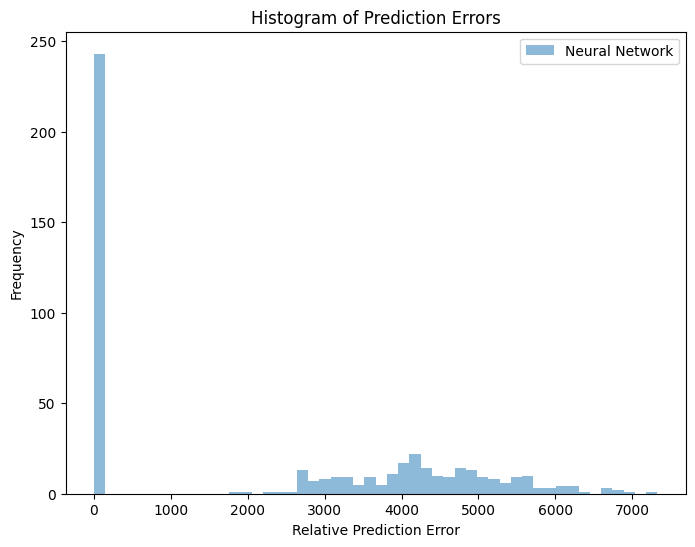

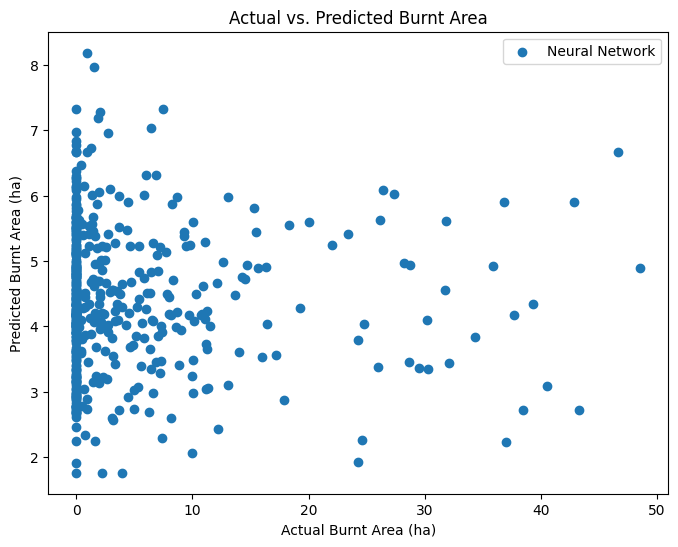

In [14]:
# Histogram of Prediction Errors
plt.figure(figsize=(8, 6))
plt.hist(np.abs(nn_predictions - df['area']) / df['area'], bins=50, alpha=0.5, label='Neural Network')
plt.xlabel('Relative Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.show()

# Scatter Plot of Actual vs. Predicted Burnt Area
plt.figure(figsize=(8, 6))
plt.scatter(df['area'], nn_predictions, label='Neural Network')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Predicted Burnt Area (ha)')
plt.title('Actual vs. Predicted Burnt Area')
plt.legend()
plt.show()


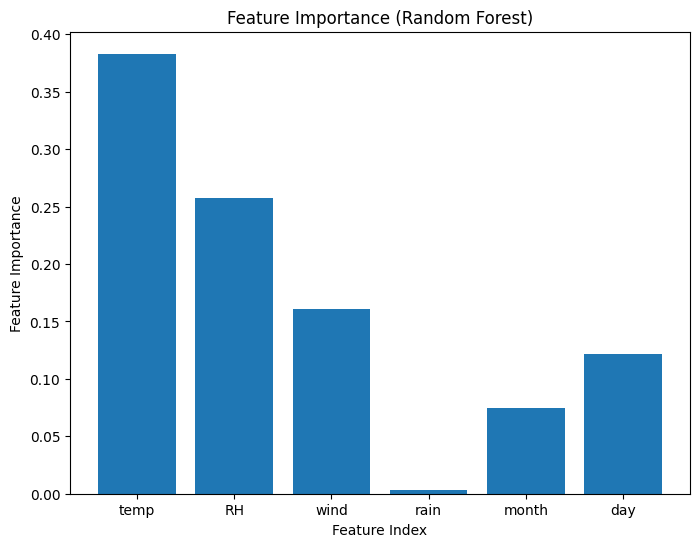

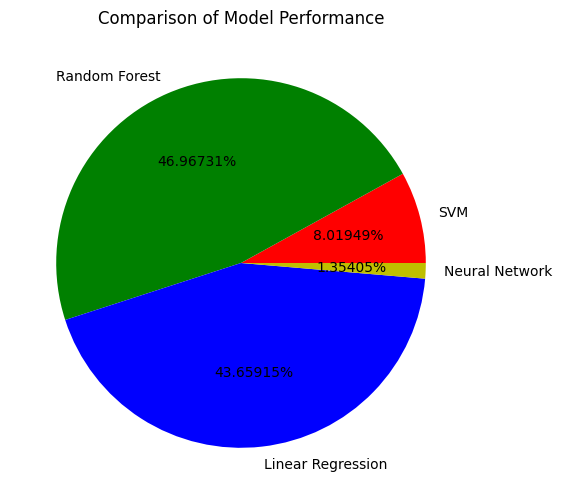

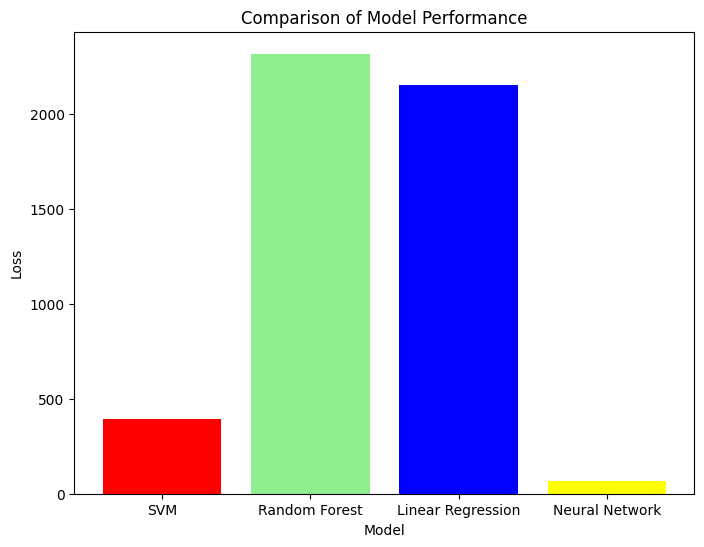

In [15]:
# Feature Importance Plots for Random Forest Model
# it is a measure of how much a feature contributes to the prediction of the target variable.
importance = rf_model.feature_importances_   #['temp', 'RH', 'wind', 'rain', 'month', 'day']
plt.figure(figsize=(8, 6))
plt.bar(['temp', 'RH', 'wind', 'rain', 'month', 'day'], importance, align='center')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Pie Chart of Model Performance
plt.figure(figsize=(8, 6))
plt.pie([total_loss_vegetation_svm, total_loss_vegetation_rf, total_loss_vegetation_lr, mean_nn_loss], labels=['SVM', 'Random Forest', 'Linear Regression', 'Neural Network'], colors=['r', 'g', 'b', 'y'], autopct='%1.5f%%')
plt.title('Comparison of Model Performance')
plt.show()

# Comparison of Model Performance
models = ['SVM', 'Random Forest', 'Linear Regression', 'Neural Network']
losses = [total_loss_vegetation_svm, total_loss_vegetation_rf, total_loss_vegetation_lr, mean_nn_loss]
colors = ['red', 'lightgreen', 'blue', 'yellow']
plt.figure(figsize=(8, 6))
plt.bar(models, losses, color=colors, align='center')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Comparison of Model Performance')
plt.show()

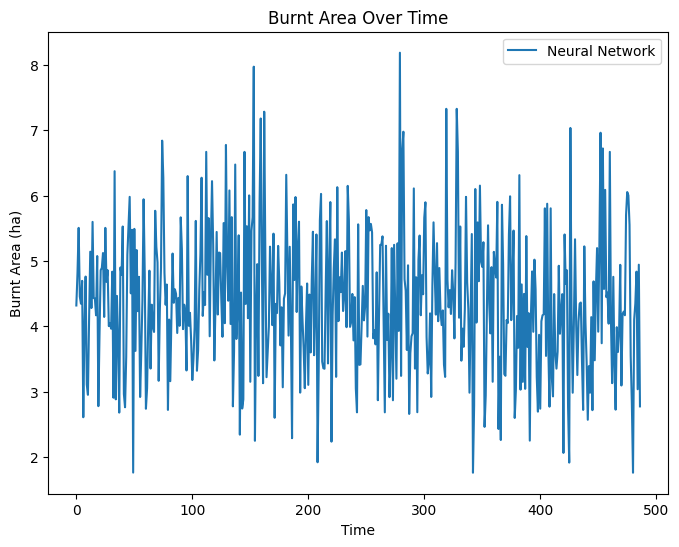

In [16]:
# Line Chart
plt.figure(figsize=(8, 6))
plt.plot(nn_predictions, label='Neural Network')
plt.xlabel('Time')
plt.ylabel('Burnt Area (ha)')
plt.title('Burnt Area Over Time')
plt.legend()
plt.show()


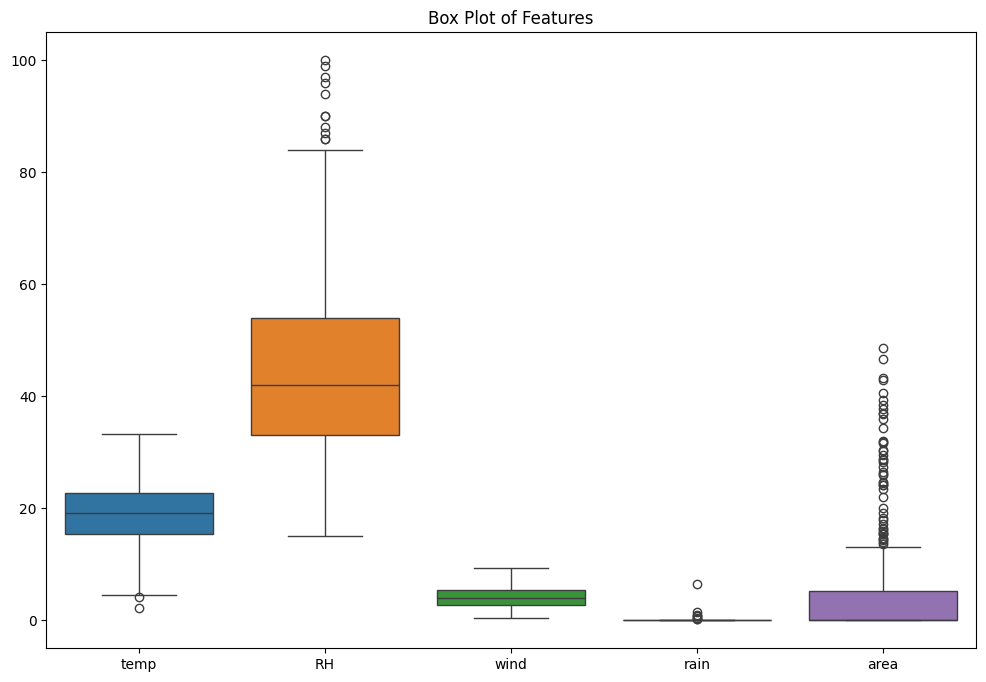

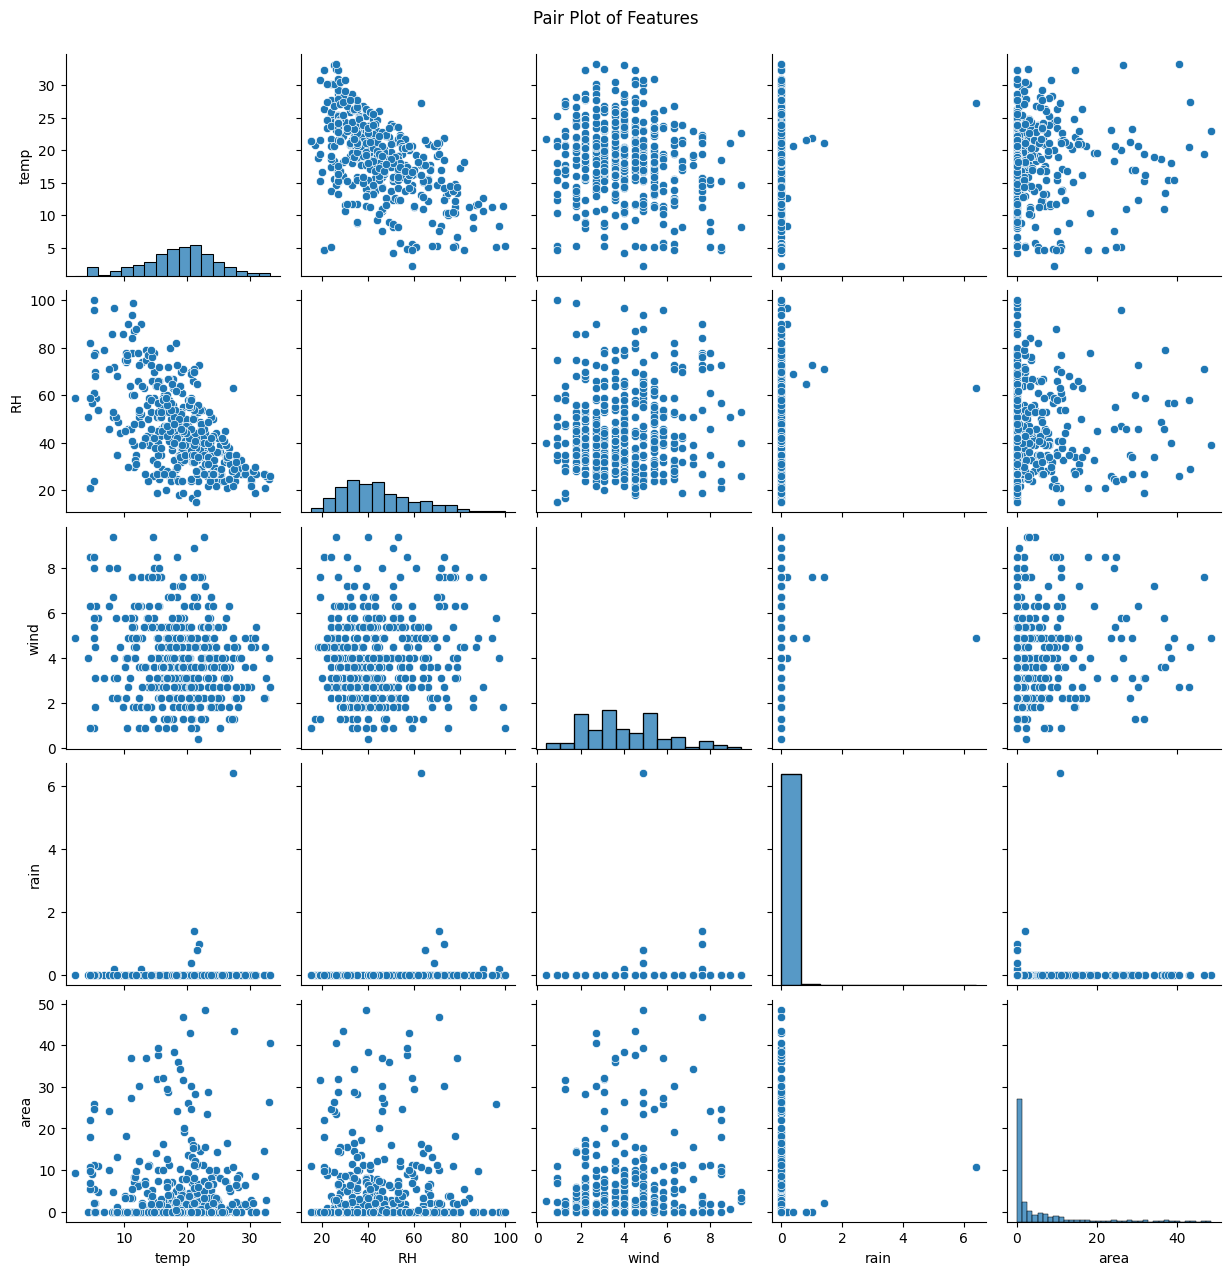

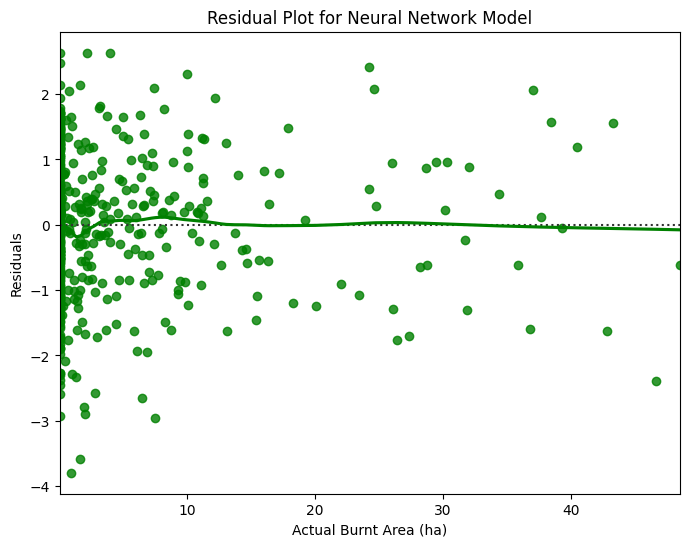

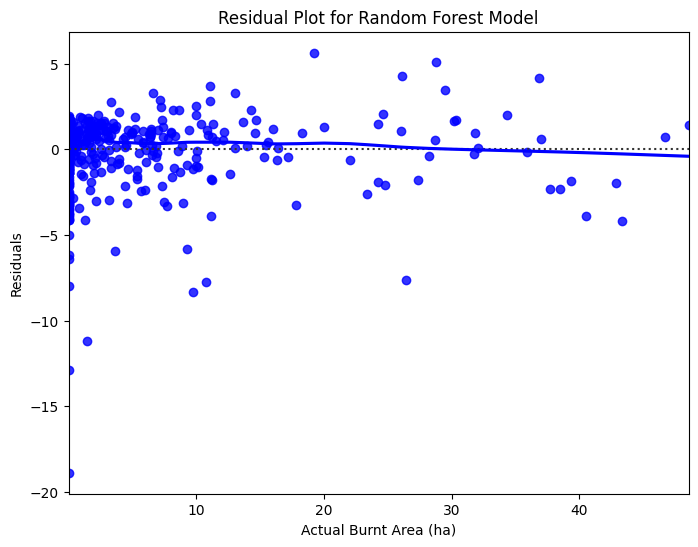

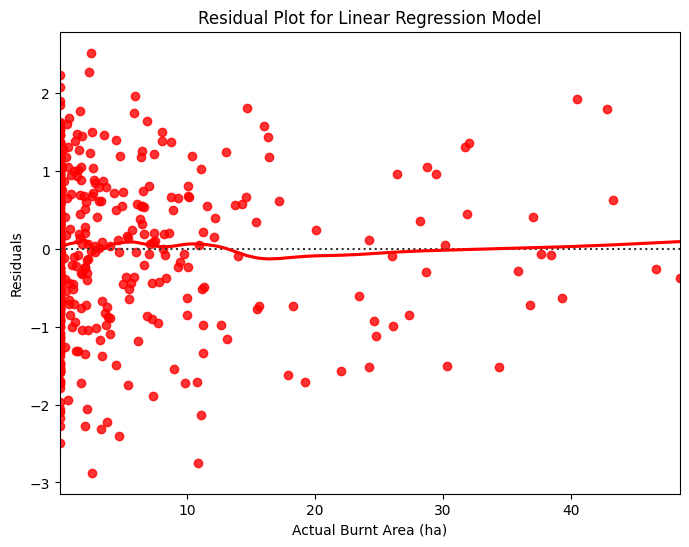

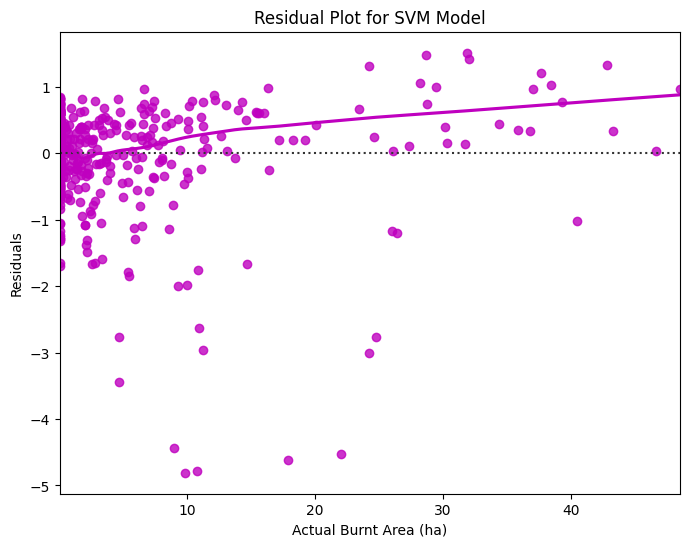

In [17]:

# Box Plot of Features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['temp', 'RH', 'wind', 'rain', 'area']])
plt.title('Box Plot of Features')
plt.show()

# Pair Plot
sns.pairplot(df[['temp', 'RH', 'wind', 'rain', 'area']])
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

# Residual Plot for Neural Network Model
nn_residuals = df['area'] - nn_predictions
plt.figure(figsize=(8, 6))
sns.residplot(x=df['area'], y=nn_residuals, lowess=True, color='g')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Neural Network Model')
plt.show()

# Residual Plot for Random Forest Model
rf_residuals = df['area'] - rf_predictions
plt.figure(figsize=(8, 6))
sns.residplot(x=df['area'], y=rf_residuals, lowess=True, color='b')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Model')
plt.show()

# Residual Plot for Linear Regression Model
lr_residuals = df['area'] - lr_predictions
plt.figure(figsize=(8, 6))
sns.residplot(x=df['area'], y=lr_residuals, lowess=True, color='r')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression Model')
plt.show()

# Residual Plot for SVM Model
svm_residuals = df['area'] - svm_predictions
plt.figure(figsize=(8, 6))
sns.residplot(x=df['area'], y=svm_residuals, lowess=True, color='m')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Residuals')
plt.title('Residual Plot for SVM Model')
plt.show()